In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

/home/rising/thesis-da/lib/python3.10/site-packages/polars/_cpu_check.py:232: RuntimeWarning: Missing required CPU features.

The following required CPU features were not detected:
    ssse3, sse4.1, sse4.2, popcnt
Continuing to use this version of Polars on this processor will likely result in a crash.
Install the `polars-lts-cpu` package instead of `polars` to run Polars with better compatibility.

Hint: If you are on an Apple ARM machine (e.g. M1) this is likely due to running Python under Rosetta.
It is recommended to install a native version of Python that does not run under Rosetta x86-64 emulation.

If you believe this warning to be a false positive, you can set the `POLARS_SKIP_CPU_CHECK` environment variable to bypass this check.

  warnings.warn(


# This first phase is when Drain is being run

To run Drain => use `logparser3.Drain`

Elaboration:
- time: 23,24 min
- `log_format = "<Content>"`

In [3]:
input_dir = '../../data/raw' # The input directory of log file
output_dir = '../../data/prepared/drain_parser/'  # The output directory of parsing results
log_file = 'unificated.ndjson'  # The input log file name
log_format = '<Content>' # Define log format to split message fields
# Regular expression list for optional preprocessing (default: [])
regex = [
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)' # IP
]
st = 0.5  # Similarity threshold
depth = 4  # Depth of all leaf nodes

In [3]:
from logparser.Drain import LogParser

parser = LogParser(log_format, indir=input_dir, outdir=output_dir,  depth=depth, st=st, rex=regex)
parser.parse(log_file)

Parsing file: ../../data/raw/unificated.ndjson
Total lines:  1939207
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.3% of log lines.
Processed 0.3% of log lines.
Processed 0.4% of log lines.
Processed 0.4% of log lines.
Processed 0.5% of log lines.
Processed 0.5% of log lines.
Processed 0.6% of log lines.
Processed 0.6% of log lines.
Processed 0.7% of log lines.
Processed 0.7% of log lines.
Processed 0.8% of log lines.
Processed 0.8% of log lines.
Processed 0.9% of log lines.
Processed 0.9% of log lines.
Processed 1.0% of log lines.
Processed 1.0% of log lines.
Processed 1.1% of log lines.
Processed 1.1% of log lines.
Processed 1.2% of log lines.
Processed 1.2% of log lines.
Processed 1.3% of log lines.
Processed 1.3% of log lines.
Processed 1.4% of log lines.
Processed 1.4% of log lines.
Processed 1.5% of log lines.
Processed 1.5% of log lines.
Processed 1.6% of log lines.
Processed 1.7% of log lines.
Pro

# After that, we can continue doing the normal LSTM anaysis

In [4]:
dlp = pl.read_csv(output_dir + "unificated.ndjson_structured.csv")

In [5]:
dlp.head(2)

LineId,Content,EventId,EventTemplate,ParameterList
i64,str,str,str,str
1,"""{""userAgent"": …","""727cfaa5""","""{""userAgent"": …","""['""Boto3/1.9.2…"
2,"""{""userAgent"": …","""b64554f3""","""{""userAgent"": …","""['""Boto3/1.9.2…"


In [6]:
dlp.filter(pl.col("EventId").is_null())

LineId,Content,EventId,EventTemplate,ParameterList
i64,str,str,str,str


In [7]:
dlp.select(pl.col("LineId", "EventId"))

LineId,EventId
i64,str
1,"""727cfaa5"""
2,"""b64554f3"""
3,"""441857d8"""
4,"""830d71fb"""
5,"""9cbef795"""
…,…
1939203,"""830d71fb"""
1939204,"""9cbef795"""
1939205,"""727cfaa5"""


In [8]:
dlp_np = dlp.select(pl.col("LineId", "EventId")).to_numpy()
dlp_np

array([[1, '727cfaa5'],
       [2, 'b64554f3'],
       [3, '441857d8'],
       ...,
       [1939205, '727cfaa5'],
       [1939206, '57cea39a'],
       [1939207, '727cfaa5']], dtype=object)

In [9]:
ord_dict = dlp.select(pl.col("EventId")).unique().to_numpy()
ord_dict.shape

(1168, 1)

In [10]:
new_df_support_array = []

for index, elem in enumerate(ord_dict):
  new_df_support_array.append((index+1, elem.item()))

token_mapping = pl.DataFrame(new_df_support_array)
token_mapping = token_mapping.rename({
    "column_0": "value",
    "column_1": "EventId"
})

token_mapping

value,EventId
i64,str
1,"""b38b5495"""
2,"""81ff1cda"""
3,"""46d60bfb"""
4,"""b1a51123"""
5,"""f55aa546"""
…,…
1164,"""ab65fb5e"""
1165,"""26a02e2e"""
1166,"""3b46693b"""


In [11]:
token_mapping.write_csv(output_dir + "token_mapping.csv")

In [12]:
del new_df_support_array
del dlp_np

In [13]:
token_mapping = pl.read_csv(output_dir + "token_mapping.csv")

In [14]:
dlp = dlp.select(pl.col("LineId", "EventId")).join(token_mapping, on="EventId")
dlp

LineId,EventId,value
i64,str,i64
1,"""727cfaa5""",1092
2,"""b64554f3""",858
3,"""441857d8""",326
4,"""830d71fb""",1041
5,"""9cbef795""",231
…,…,…
1939203,"""830d71fb""",1041
1939204,"""9cbef795""",231
1939205,"""727cfaa5""",1092


In [15]:
sw = 7

for i in range(1, sw+1):
  dlp = dlp.with_columns(
      pl.Series(dlp["value"]).shift(i).alias(f"t-{i}")
  )
dlp = dlp.drop_nulls().select(pl.col("*").exclude("EventId"))
dlp

LineId,value,t-1,t-2,t-3,t-4,t-5,t-6,t-7
i64,i64,i64,i64,i64,i64,i64,i64,i64
8,1092,357,1092,231,1041,326,858,1092
9,1092,1092,357,1092,231,1041,326,858
10,858,1092,1092,357,1092,231,1041,326
11,883,858,1092,1092,357,1092,231,1041
12,1041,883,858,1092,1092,357,1092,231
…,…,…,…,…,…,…,…,…
1939203,1041,326,858,1092,1092,357,231,1041
1939204,231,1041,326,858,1092,1092,357,231
1939205,1092,231,1041,326,858,1092,1092,357


<Axes: xlabel='LineId', ylabel='value'>

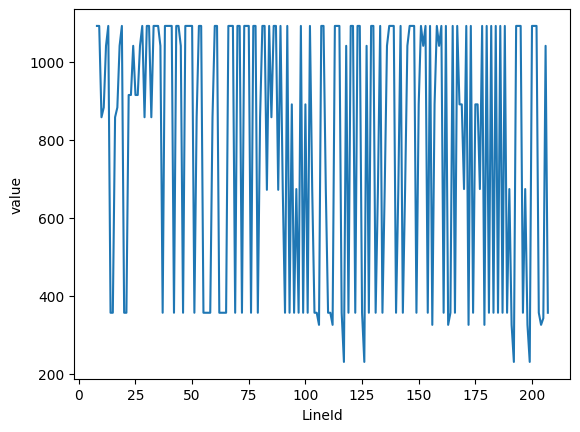

In [16]:
sns.lineplot(data=dlp[:200].to_pandas(), y="value", x="LineId")

In [17]:
shifted_np = dlp.to_numpy()
shifted_np

array([[      8,    1092,     357, ...,     326,     858,    1092],
       [      9,    1092,    1092, ...,    1041,     326,     858],
       [     10,     858,    1092, ...,     231,    1041,     326],
       ...,
       [1939205,    1092,     231, ...,    1092,    1092,     357],
       [1939206,     357,    1092, ...,     858,    1092,    1092],
       [1939207,    1092,     357, ...,     326,     858,    1092]])

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_np = scaler.fit_transform(shifted_np)

shifted_np

array([[-1.        ,  0.8697515 , -0.3898886 , ..., -0.44301628,
         0.46872322,  0.8697515 ],
       [-0.99999897,  0.8697515 ,  0.8697515 , ...,  0.7823479 ,
        -0.44301628,  0.46872322],
       [-0.99999794,  0.46872322,  0.8697515 , ..., -0.60582691,
         0.7823479 , -0.44301628],
       ...,
       [ 0.99999794,  0.8697515 , -0.60582691, ...,  0.8697515 ,
         0.8697515 , -0.3898886 ],
       [ 0.99999897, -0.3898886 ,  0.8697515 , ...,  0.46872322,
         0.8697515 ,  0.8697515 ],
       [ 1.        ,  0.8697515 , -0.3898886 , ..., -0.44301628,
         0.46872322,  0.8697515 ]])

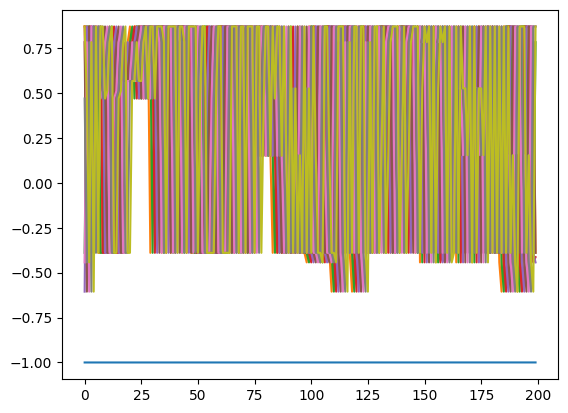

In [19]:
plt.plot(shifted_np[:200])

plt.show()

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
X = shifted_np[:, 2:]
y = shifted_np[:, 1]

X.shape, y.shape

((1939200, 7), (1939200,))

In [22]:
from copy import deepcopy as dc

X = dc(np.flip(X, axis=1))
X

array([[ 0.8697515 ,  0.46872322, -0.44301628, ..., -0.60582691,
         0.8697515 , -0.3898886 ],
       [ 0.46872322, -0.44301628,  0.7823479 , ...,  0.8697515 ,
        -0.3898886 ,  0.8697515 ],
       [-0.44301628,  0.7823479 , -0.60582691, ..., -0.3898886 ,
         0.8697515 ,  0.8697515 ],
       ...,
       [-0.3898886 ,  0.8697515 ,  0.8697515 , ..., -0.44301628,
         0.7823479 , -0.60582691],
       [ 0.8697515 ,  0.8697515 ,  0.46872322, ...,  0.7823479 ,
        -0.60582691,  0.8697515 ],
       [ 0.8697515 ,  0.46872322, -0.44301628, ..., -0.60582691,
         0.8697515 , -0.3898886 ]])

In [23]:
where_to_split = 0.90

split_index = int(len(X)*where_to_split)
split_index

1745280

In [24]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1745280, 7), (193920, 7), (1745280,), (193920,))

In [25]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1745280, 7]),
 torch.Size([1745280]),
 torch.Size([193920, 7]),
 torch.Size([193920]))

In [26]:
X_train = X_train.reshape((-1, sw, 1))
X_test = X_test.reshape((-1, sw, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape # see if they match up, here

(torch.Size([1745280, 7, 1]),
 torch.Size([193920, 7, 1]),
 torch.Size([1745280, 1]),
 torch.Size([193920, 1]))

In [27]:
from torch.utils.data import Dataset

class FlawsLogDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]


In [28]:
train_dataset = FlawsLogDataset(X_train, y_train)
test_dataset = FlawsLogDataset(X_test, y_test)

In [29]:
from torch.utils.data import DataLoader

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([2048, 7, 1]) torch.Size([2048, 1])


In [31]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()

    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, 1, :])
    return out

model = LSTM(1, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
def train_one_epoch():
  model.train(True)
  print(f"Epoch: {epoch+1}")
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss/100
      print("Batch {0}, Loss {1:.5f}".format(
          batch_index+1,
          avg_loss_across_batches
      ))
      running_loss = 0.0

In [33]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

  print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
  print('***************************************************')

In [34]:
learning_rate = 1e-3
num_epochs = 300

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

  torch.save(model, "../../data/prepared/model/drainLSTM_300epc.pth")


Epoch: 1
Batch 100, Loss 0.32131
Batch 200, Loss 0.30648
Batch 300, Loss 0.30619
Batch 400, Loss 0.30535
Batch 500, Loss 0.30535
Batch 600, Loss 0.30566
Batch 700, Loss 0.30678
Batch 800, Loss 0.30511
Val Loss: 0.303
***************************************************
Epoch: 2
Batch 100, Loss 0.30553
Batch 200, Loss 0.30510
Batch 300, Loss 0.30517
Batch 400, Loss 0.30620
Batch 500, Loss 0.30577
Batch 600, Loss 0.30556
Batch 700, Loss 0.30547
Batch 800, Loss 0.30590
Val Loss: 0.303
***************************************************
Epoch: 3
Batch 100, Loss 0.30488
Batch 200, Loss 0.30510
Batch 300, Loss 0.30424
Batch 400, Loss 0.30105
Batch 500, Loss 0.29944
Batch 600, Loss 0.29874
Batch 700, Loss 0.29816
Batch 800, Loss 0.29930
Val Loss: 0.297
***************************************************
Epoch: 4
Batch 100, Loss 0.29855
Batch 200, Loss 0.29691
Batch 300, Loss 0.29746
Batch 400, Loss 0.29693
Batch 500, Loss 0.29665
Batch 600, Loss 0.29620
Batch 700, Loss 0.29742
Batch 800, Loss 

KeyboardInterrupt: 

In [ ]:
torch.save(model, "../../data/prepared/model/drainLSTM_5epc.pth")

In [ ]:
model = torch.load("currently_trained.pth")

In [ ]:
y_train.shape, X_train.shape, X_test.shape

In [ ]:
y_train[1], X_train[1], X_test[1]

In [ ]:
X_test[2048], y_test[2048]

In [ ]:
to_get = 150

with torch.no_grad():
    predicted = model(X_test[:to_get]).to(device).to('cpu').numpy()

predicted

In [ ]:
plt.plot(y_test[:to_get], label='Real Log Template')
plt.plot(predicted, label='Predicted Log Template')
plt.xlabel('Time')
plt.ylabel('Log Template')
plt.legend()
plt.show()